In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

def rough_plot(in_list, num_group):
    rough_list = list()
    tmp_sum = 0
    
    for i in range(1, len(in_list)):
        tmp_sum += in_list[i]
    
        if(i%num_group == num_group-1):
            rough_list.append(tmp_sum / num_group)
            tmp_sum = 0
            
    plt.plot(rough_list)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linear_pred(li_in):
    li = li_in.copy()
    
    li_arr = np.asarray(li)
    li_arr = np.reshape(li_arr, (len(li), 1))
    x_arr = np.arange(len(li))
    x_arr = np.reshape(x_arr, (len(li), 1))

    regr = linear_model.LinearRegression()
    regr.fit(x_arr, li_arr)
    pred = regr.predict(len(li))
    return pred[0, 0]


In [4]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level) or action < 0:
        print("action = ", action)
        sys.exit("error, action undefined! nxt")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest

def my_reward(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
       
def penalty_reward(curr, last):
    penalty_multiplier = 10
    k = (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
    if k < 0:
        k = k*penalty_multiplier
    return k



In [5]:
# feature 1 : indicate the difference of #stock after the action from the state
# state is a dictionary with 3 elements
def feature_1(state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f1")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (state['HandCash']/state['StockPrice'])*(action/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = (-1)*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    #elif action == (2*action_level + 1): # hold
    elif action == 0: # hold
        return 0
feature_1.max = 1
feature_1.min = 0
    

# feature 2 : indicate the difference of #Cash in Hand after the action from the state
def feature_2(state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f2")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (-1)*state['HandCash'] * (action/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = state['StockPrice']*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    #elif action == (2*action_level + 1): # hold
    elif action == 0: # hold
        return 0
feature_2.max = 1
feature_2.min = 0

    
# linear_based_rwd    
def feature_3(price_list, state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f3")
    
    #next_price = linear_pred(price_list)
    next_price = sum(price_list)/len(price_list)
    
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
        
    tmp = my_reward(next_s, state)
    if tmp > feature_3.max:
        feature_3.max = tmp
        return 1
    elif tmp < feature_3.min:
        feature_3.min = tmp
        return 0
    else:
        return (tmp - feature_3.min) / (feature_3.max - feature_3.min)
    
    #return my_reward(next_s, state)/100
feature_3.max = 1
feature_3.min = 0


def feature_4(price_list, state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f4")
    
    #next_price = linear_pred(price_list)
    next_price = sum(price_list)/len(price_list)
    
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
    
    if next_price >= state['StockPrice']:
        best_action = action_level # buy with all cash u have
    else:
        best_action = 2*action_level # sell all stocks u have
    best_next_s = next_state(state, best_action, action_level)
    best_next_s['StockPrice'] = next_price
    
    
    tmp = my_reward(best_next_s, state) - my_reward(next_s, state)
    #print("action, tmp = ", action, tmp)
    if tmp > feature_4.max:
        feature_4.max = tmp
        return 1
    elif tmp < feature_4.min:
        feature_4.min = tmp
        return 0
    else:
        return (tmp - feature_4.min) / (feature_4.max - feature_4.min)
feature_4.max = 1
feature_4.min = 0

def feature_5_conti(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    sinter = inter/100 # scaled inter
    if((k_yestd > d_yestd and k_today < d_today and inter > 50) or \
       (k_yestd < d_yestd and k_today > d_today and inter < 50)):
        # saction= sell all:1, sell:1~0.5, hold:0.5, buy:0.5~0, buy all:0
        # the diff btw saction & sinter(i.e. inter/100) : smaller is better(then return larger value)
        
        if(action <= action_level):
            saction = (action_level - action)/(2*action_level) # scaled action
        else:
            saction = action/(2*action_level)
            
        return 1-abs(sinter-saction)
        
    else: # best to hold
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
# from feature_6_my  
def feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    if(k_yestd < d_yestd and k_today > d_today and inter < 30): # buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
       
    elif(k_yestd > d_yestd and k_today < d_today and inter > 70): # sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
    else:
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
def psy(price_list):
    n = 0
    for i in range(1, len(price_list)):
        if price_list[i] > price_list[i-1]:
            n += 1
    return (n/float(len(price_list) - 1))*100


def feature_6_original(price_list,action,action_level):
    psy_num = psy(price_list)
    if(psy_num <= 25): # market oversell we can buy
        if(action <= action_level):
            return (action + action_level + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action - action_level)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
    if(25 < psy_num < 75):#hold to observe situation
        if(action <= action_level):
            return 2*(action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return 2*(2*action_level - action + 1)/float(2*action_level + 1)
        else:
            return 1
    if(psy_num >= 75):#market overbuy we can sell
        if(action <= action_level):
            return (action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action + 1)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
        
        
def feature_6_dis(price_list, action, action_level):
    psy_num = psy(price_list)
    if(psy_num <= 25): # market oversell we can buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
        
    if(25 < psy_num < 75):#hold to observe situation
        if(action <= action_level):
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
        
    if(psy_num >= 75):#market overbuy we can sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
        
def feature_6_conti(price_list, action, action_level):
    psy_num = psy(price_list)
    spsy_num = psy_num/100

    if(action <= action_level):
        saction = (action_level - action)/(2*action_level) # scaled action
    else:
        saction = action/(2*action_level)
            
    return 1-abs(spsy_num-saction)


def feature_7(price_list, state, action, action_level):
    if(action > 2*action_level) or action < 0:
        sys.exit("error, action undefined!")
        
    price_avg = sum(price_list) / float(len(price_list))
    
    #stock price is higher than avg_price means the stock is going up
    if price_avg <= state['StockPrice']:
        price_trend = 1
    else:
        price_trend = 0
    
    #stock is going up, we should buy
    if price_trend == 1:
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
    #stock is going down, sell
    elif price_trend == 0:
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
        
def list_rev_count(inlist):
    ret = 0
    for i in range(2, len(inlist)):
        if (inlist[i] - inlist[i-1]) * (inlist[i-1] - inlist[i-2]) < 0:
            ret = ret + 1
    return ret

def feature_8_vari(price_list, action, action_level):
    if(action > 2*action_level) or action < 0:
        sys.exit("error, action undefined!")
    
    revcount = list_rev_count(price_list)
    
    if revcount > len(price_list) / 3:  # best to hold
        if(action <= action_level): 
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    else:
        return 0

Note: feature3 and feature4 is hard code with the reward function : my_reward  
  
feature1: 做了某action後，portfolio中股票的變化量  
feature2: 做了某action後，portfolio中現金的變化量  
feature3: 假設下個價格為線性回歸預測的結果。現在做了某action，接著價格由目前價格變為下個價格後，portfolio價值的變化量  
feature4: 假設下個價格為線性回歸預測的結果。（最佳action替portfolio增加的價值 - 某action替portfolio增加的價值）

In [6]:
from random import randint

def Q_value(k_today, d_today, k_yestd, d_yestd, 
            price_list,
            state, action, w, action_level, choose_feature):
    
    """
    :param price_list: the input of feature_3 and feature_4
    :param k_today, d_today, k_yestd, d_yestd: the input of feature_5
    :return: num
    """
            
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! Q")
        
    ret = 0
    
    if(choose_feature[0]):
        ret = ret + w[0]*feature_1(state, action, action_level)
    if(choose_feature[1]):
        ret = ret + w[1]*feature_2(state, action, action_level)
    if(choose_feature[2]):
        ret = ret + w[2]*feature_3(price_list, state, action, action_level)
    if(choose_feature[3]):
        ret = ret + w[3]*feature_4(price_list, state, action, action_level)
    if(choose_feature[4]):
        ret = ret + w[4]*feature_5(k_today, d_today, k_yestd, d_yestd, action, action_level)
    if(choose_feature[5]):
        ret = ret + w[5]*feature_6(price_list, action ,action_level)  
    if(choose_feature[6]):
        ret = ret + w[6]*feature_7(price_list, state, action, action_level) 
    if(choose_feature[7]):
        ret = ret + w[7]*feature_8_vari(price_list, action, action_level)
    
    #print('------------------')
    #print(feature_7(price_list_f7, state, action, action_level))
    #print(action)
    #print(ret)
    #print('------------------')
    
    return ret
    

def V_value(k_today, d_today, k_yestd, d_yestd, price_list, state,
            w, action_level, choose_feature):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(0, (2*action_level + 1)):
        curr_q = Q_value(k_today, d_today, k_yestd, d_yestd, price_list,
                         state, action, w, action_level, choose_feature)
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
    
    # add the if statement when u want to know the effective action. don't add when u want to know the intented action
    #if v == Q_value(k_today, d_today, k_yestd, d_yestd, price_list, state, 0, w, action_level):
        #v_act = 0
        
        
    #print("[v, v_act] = ", [v, v_act])
    return [v, v_act]

In [7]:
import math
from fractions import Fraction

class StockQLData:
    'Result data of approximated q-learning of stock price'
    
    def __init__(self, action_level, data_len, ratio_num_local, trial_range):
        self.last_reward = list()
        
        self.last_w = list()
        
        self.rwd_sum = 0
        self.avg_point_rwd = list()

        self.act_num = np.zeros(action_level*2 + 1)
        self.act_num_list = list()

        self.ratio_local_size = math.floor(data_len/ratio_num_local)
        self.tmp_local_act_num = np.zeros(action_level*2 + 1)
        self.tmp_trial_act_ratio = list()
        self.act_ratio = list() # all_trial_act_ratio
        
        self.trial_range = trial_range # for the default argumant of print_local_act_ratio
        
    def point_update_action_num(self, last_act):
        self.act_num[last_act] += 1

    
    def point_update_rwd_sum(self, state, last_state, avg_point_rwd_func):
        self.rwd_sum += avg_point_rwd_func(state, last_state) 
        
    def point_update_action_ratio(self, last_act, data_index):        
        self.tmp_local_act_num[last_act] += 1
        if (data_index+1) % self.ratio_local_size == 0:
            self.tmp_trial_act_ratio.append(self.tmp_local_act_num/self.tmp_local_act_num.sum())
            self.tmp_local_act_num.fill(0)
            
        
    def last_point(self, trial_length, state, init_invest, w, last_rwd_func):
        self.avg_point_rwd.append(self.rwd_sum/(trial_length-1)) #ignore the first reward(=0)
        self.rwd_sum = 0
        
        self.last_reward.append(last_rwd_func(state, init_invest))
        
        cp_w = w.copy()
        self.last_w.append(cp_w)

        tmp_act_num = self.act_num.copy()
        self.act_num_list.append(tmp_act_num)
        self.act_num.fill(0)
        
        if np.count_nonzero(self.tmp_local_act_num) > 0:
            self.tmp_trial_act_ratio.append(self.tmp_local_act_num/self.tmp_local_act_num.sum())
            self.tmp_local_act_num.fill(0)
        self.act_ratio.append(self.tmp_trial_act_ratio.copy())
        del self.tmp_trial_act_ratio[:] # empty the list

        
    def __act_ratio_prepare_print(self, start, end, alcnum, action_level): # the start/end trial index(can not recognize in the plot, just where data come from), actual number of local(i.e. group)
        ret = list()
        
        # initialize
        for i in range(0, alcnum):  # alcnum
            ret.append(np.zeros(action_level*2 + 1))
            
        trind = start
        lcind = 0
        for trind in range(start, end+1):
            for lcind in range(0, alcnum):
                for actind in range(0, action_level*2 + 1):
                    ret[lcind][actind] += sqld.act_ratio[trind][lcind][actind] / (end - start + 1)
        return ret

        
    # print the series with local rate ratio
    def print_local_act_ratio(self, data, action_level, start_trind=0, end_trind=None):
        if end_trind is None:
            end_trind = trial_range - 1
        
        alcnum = len(sqld.act_ratio[0]) # actual number of local(i.e. group)
        
        to_plot = self.__act_ratio_prepare_print(start_trind, end_trind, alcnum, action_level)
        
        sf, saxarr = plt.subplots(alcnum, 2, figsize=(9, 4*alcnum)) # print all local by now
        
        row_count = 0
        
        pie_labels = ["hold"]
        for i in range(1, action_level+1):
            pie_labels.append("{0} buy".format(Fraction(i, action_level)))
        for i in range(1, action_level+1):
            pie_labels.append("{0} sell".format(Fraction(i, action_level)))
            
        for lcind in range(0, alcnum): # print all local by now
            tmp_data = data.copy()
            tmp_data = tmp_data[sqld.ratio_local_size*lcind : sqld.ratio_local_size*(lcind + 1)]
            
            saxarr[row_count, 0].plot(tmp_data)
            saxarr[row_count, 0].set_title('close_price')
            
            saxarr[row_count, 1].pie(to_plot[lcind], labels=pie_labels)
            saxarr[row_count, 1].set_title('act_ratio')
            
            
            row_count += 1
        

after an action ---> call it the (new) state  
here: last_state_bf_act -> |act| -> last_state -> |new price release| -> (new) state  
but the last_state can be dismiss because when calculating(my_reward), it can be alternated by last_state_bf_act and keep the rule of the first line(i.e. after an action ---> call it the (new) state)

In [8]:
relist = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', '^N225.csv', '^GDAXI.csv', \
          '^IXIC.csv', '^KS11.csv', '^SSEC.csv', \
         'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv']
#relist = ['QCOM.csv']
#relist = ['NSU.DE_10_5_5.csv']
for resource_data in relist:
    input_csv = "./input/{0}".format(resource_data)
    qcom = pd.read_csv(input_csv)

    qclose = qcom['Close']

    qclose = qclose.fillna(qclose.median())

    qclose = qclose.tolist()

    np.isnan(qclose).any()

    action_level = 3


    last_rwd_func = reward
    work_rwd_func = penalty_reward ## for updating w
    avg_point_rwd_func = my_reward



    #of candidate feature : 7
    feature_5 = feature_5_conti
    feature_6 = feature_6_dis
    choose_feature = [False, False, False, False, True, False, True, True]




    # preparing data for feature_5
    import stockstats
    qcomStockStat = stockstats.StockDataFrame.retype(qcom)
    qcomStockStat[['kdjk','kdjd','kdjj']]
    qkdjk = qcomStockStat['kdjk'].tolist()
    qkdjd = qcomStockStat['kdjd'].tolist()



    from random import randint
    import math

    init_invest = 10000
    # initial state
    state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
    last_state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
    last_state_bf_act = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}

    last_act = action_level

    init_w = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    w = init_w.copy()
    tmp_w = [0, 0, 0, 0, 0, 0, 0, 0]
    ita = 0.2
    epsilon = 0.2
    gama = 0.2

    keep_w = True

    fx_num = 5


    ratio_num_local = 5
    trial_range = 100
    sqld = StockQLData(action_level, len(qclose), ratio_num_local, trial_range)
    
    
    for trial in range(0, trial_range):
        #print("trial = ", trial)

        state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
        last_state = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}
        last_state_bf_act = {'NumStock': 0, 'StockPrice': qclose[0], 'HandCash': init_invest}

        if not keep_w:
            for i in range(0, len(w)):
                w[i] = init_w[i] 

        for point in range(fx_num, len(qclose)):
        #for point in range(f3_x_num, 10):

            # new price revealed!
            state['NumStock'] = last_state['NumStock']
            state['HandCash'] = last_state['HandCash']
            state['StockPrice'] = qclose[point]

            # collect data           
            sqld.point_update_action_num(last_act)        
            sqld.point_update_rwd_sum(state, last_state, avg_point_rwd_func)
            sqld.point_update_action_ratio(last_act, point)
            
            #print(last_rwd_func(state, init_invest))

            if point == len(qclose)-1:
                #print('in loop watch w: ', w)
                sqld.last_point(len(qclose), state, init_invest, w, last_rwd_func)


            # prepare for the arguments passed later
            last_fx_list = qclose[point-fx_num:point]
            curr_fx_list = qclose[point-fx_num+1:point+1]

            # prepare for the arguments passed later
            last_1_k = qkdjk[point-1]  
            last_1_d = qkdjd[point-1] 
            last_2_k = qkdjk[point-2] 
            last_2_d = qkdjd[point-2] 
            now_k = qkdjk[point]
            now_d = qkdjd[point]

            # used in the w updating below
            last_Q_pred = Q_value(last_1_k, last_1_d, last_2_k, last_2_d,
                                  last_fx_list, 
                                  last_state_bf_act, last_act, w, action_level, choose_feature)
            target = (work_rwd_func(state, last_state) + gama*V_value(now_k, now_d, last_1_k, last_1_d, 
                                                                      curr_fx_list,
                                                                      state, w, action_level, choose_feature)[0])



            if(choose_feature[0]):
                tmp_w[0] = w[0] - ita * (last_Q_pred - target) * \
                                  feature_1(last_state_bf_act, last_act, action_level)
            if(choose_feature[1]):        
                tmp_w[1] = w[1] - ita * (last_Q_pred - target) * \
                                  feature_2(last_state_bf_act, last_act, action_level)
            if(choose_feature[2]):        
                tmp_w[2] = w[2] - ita * (last_Q_pred - target) * \
                                  feature_3(last_fx_list, last_state_bf_act, last_act, action_level)
            if(choose_feature[3]):
                tmp_w[3] = w[3] - ita * (last_Q_pred - target) * \
                                  feature_4(last_fx_list, last_state_bf_act, last_act, action_level)
            if(choose_feature[4]):
                tmp_w[4] = w[4] - ita * (last_Q_pred - target) * \
                                  feature_5(last_1_k, last_1_d, last_2_k, last_2_d, last_act, action_level)
            if(choose_feature[5]):
                tmp_w[5] = w[5] - ita * (last_Q_pred - target) * \
                                  feature_6(last_fx_list, last_act, action_level)
            if(choose_feature[6]):
                tmp_w[6] = w[6] - ita * (last_Q_pred - target) * \
                                  feature_7(last_fx_list, last_state_bf_act, last_act, action_level)
            if(choose_feature[7]):
                tmp_w[7] = w[7] - ita * (last_Q_pred - target) * \
                                  feature_8_vari(last_fx_list, last_act, action_level)

            for i in range(0, len(w)):
                w[i] = tmp_w[i] 


            last_state_bf_act = state.copy()

            # determine the next state
            if randint(1, 10) <= 10*epsilon:
                # act randomly
                last_act = randint(0, 2*action_level)
            else:
                last_act = (V_value(now_k, now_d, last_1_k, last_1_d, 
                                    curr_fx_list,
                                    state, w, action_level, choose_feature))[1]
                #print(last_act)

            last_state = next_state(state, last_act, action_level)
        
    print(resource_data, sum(sqld.last_reward) / float(len(sqld.last_reward)))
    #rough_plot(sqld.last_reward, 2)

QCOM.csv 1937.4970026521055
GOOG.csv 3880.620961823425
NOK.csv 21195.956046409145
^DJI.csv 2637.5655951782037
^TWII.csv 3415.700098626976
^N225.csv 21032.02434021934
^GDAXI.csv 10471.242189942172
^IXIC.csv 5202.568742349694
^KS11.csv 1942.977739890318
^SSEC.csv 216.55243196856622
NSU.DE_10_5_5.csv 2552532.5753112133
DAI.DE_10_5_5.csv -4110.033975893484
BMW.DE_10_5_5.csv -840.8699395978147


In [9]:
w

[0, 0, 0, 0, -80.56677441094982, 0, -92.15029033385967, 85.05713668154196]

In [10]:
sum(sqld.last_reward) / float(len(sqld.last_reward))

-840.8699395978147

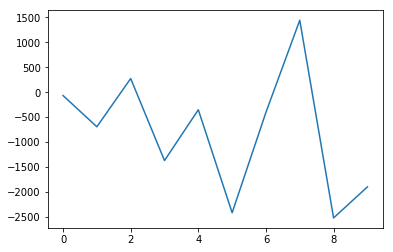

In [11]:
rough_plot(sqld.last_reward, 10)

In [12]:
sqld.ratio_local_size

508

In [13]:
sqld.last_w

[[0, 0, 0, 0, -206.78900553065174, 0, -3.367939130225672, 159.13692980525087],
 [0, 0, 0, 0, -379.21412102614516, 0, -18.260647972876768, 274.7686484770701],
 [0, 0, 0, 0, -292.4352061537698, 0, -16.61471824409005, 182.73239200575057],
 [0, 0, 0, 0, -450.28803249614134, 0, -124.00754506200536, 375.73548194964593],
 [0, 0, 0, 0, -360.9393077753895, 0, -95.67985535489868, -59.61897030721863],
 [0, 0, 0, 0, -108.92562793652587, 0, -147.2046926357589, -74.90561244502322],
 [0, 0, 0, 0, -293.97601190944863, 0, -56.04817526916488, 94.63573563778465],
 [0, 0, 0, 0, -177.48846565393313, 0, -51.71621687047662, 233.9841005479883],
 [0,
  0,
  0,
  0,
  -442.21853630629704,
  0,
  -131.76575067476375,
  -4.7825924069176065],
 [0, 0, 0, 0, -354.2479847989551, 0, -72.4061056628361, 295.0922339339159],
 [0, 0, 0, 0, -658.0116937162446, 0, -311.60447578667845, 379.9835559168182],
 [0, 0, 0, 0, -933.8218801414379, 0, -934.3810179185996, 547.0984740208288],
 [0, 0, 0, 0, -506.28509355599874, 0, -26.492

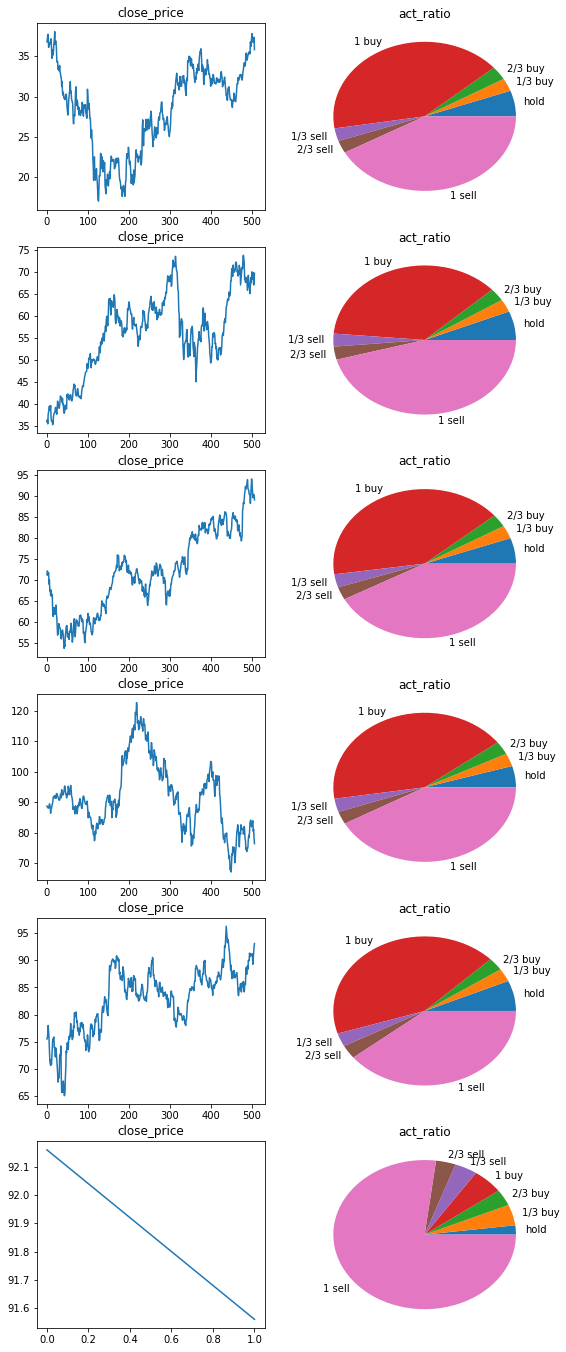

In [14]:
sqld.print_local_act_ratio(qclose, action_level)

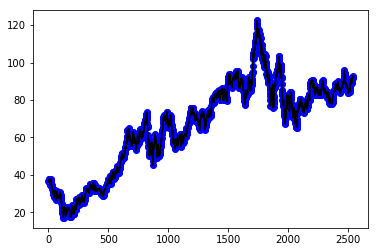

In [15]:
plt.plot(qclose, 'bo', qclose, 'k')